# FID Calculator
Notebook to compute FID scores for different models. When comparing training
and validation set, I get an FID score of 3.1503. When look at the outputs of the
last checkpoint of the diffusion model I trained, I get an FID score of 120.7927
(see last few cells).

In [37]:
import os
import sys
sys.path.append("../")

from udl_2024_package.datasets import remove_dataset_labels, default_img_transforms
from udl_2024_package.nn import unet_factory, SimpleDiscriminator
from udl_2024_package.vincent_wgan import WGANWithGradientPenalty
from udl_2024_package.vincent_diffusion import DiffusionModel

from torchmetrics.image.fid import FrechetInceptionDistance
import torch
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

from tqdm import tqdm

import pandas as pd
import re

In [38]:
# WandB config:
project_name = "udl_2025_diffusion_gan"
group_name = "experiment_02_wgan_finetune"

checkpoint_dir = "./experiment_02_wgan_finetune_models/"

config = {
    # Input data and training:
    "batch_size": 64,
    
    "dataset_cls": datasets.CIFAR10,
        "ds_name": "cifar10",   # Warning: change when changing dataset
        "num_channels": 3,      # Warning: change when changing dataset
        "img_size": 32,         # Warning: change when changing dataset
        "extra_transforms": [], # Warning: change when changing dataset

    # "dataset_cls": datasets.MNIST,
    #     "ds_name": "mnist",     # Warning: change when changing dataset
    #     "num_channels": 1,      # Warning: change when changing dataset
    #     "img_size": 32,         # Warning: change when changing dataset
    #     "extra_transforms": [   # Warning: change when changing dataset
    #         transforms.Resize(32)
    #     ],
    
    "max_epochs": 150,
    "dl_num_workers": 4,

    # WGAN model (WGAN-GP paper defaults):
    "optimizer_cls": torch.optim.Adam,
    "optimizer_args": { "lr": 1e-4, "betas": (0.5, 0.99) },
    "gp_weight": 10,
    "critic_iterations": 5,
    "lr_scaling_factor": 0.2,

    # DDPM values (not really used, but for loading checkpoint):
    "ddpm_steps": 1000,
    "ddpm_beta_start": 0.0001,
    "ddpm_beta_end": 0.02,

    # U-Net config:
    "block_out_channels": [128, 256, 256, 256],
    "layers_per_block": 2,

    # Starting point for training:
    "unet_checkpoint": "./cifar10_peachy-totem-7_epochepoch=94.ckpt",

    # Critic config:
    "cri_channel_list": [128] * 4,
    "cri_kernel_list": [3] * 4,
    "cri_downsample_list": [True] * 2 + [False] * 2
}

datasets_path = os.path.join(os.environ.get("TMPDIR", os.curdir), "datasets")

dataloader_kwargs = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": config["dl_num_workers"],
    "pin_memory": True,
}

In [39]:
ds_transforms = default_img_transforms(config["num_channels"], ) # [transforms.Resize((299,299))])
train_ds = config["dataset_cls"](datasets_path, transform=ds_transforms, download=True, train=True)
train_ds = remove_dataset_labels(train_ds)
train_dl = DataLoader(train_ds, **dataloader_kwargs)

In [40]:
# Set up FID and load in dataset
fid = FrechetInceptionDistance(
    normalize=True, input_img_size=(3,32,32),
    reset_real_features=False).to("cuda")
for batch in tqdm(train_dl):
    batch = batch.to("cuda") * 0.5 + 0.5
    fid.update(batch, True)

100%|██████████| 782/782 [01:57<00:00,  6.66it/s]


## Computing FID Scores for WGAN models

In [41]:
# Function to load checkpoint and return the generator:

def generate_samples(generator, real_batch):
    noise = torch.randn_like(real_batch)
    ts = torch.full((len(real_batch),), 999, device=real_batch.device)
    return generator(noise, ts)

def load_checkpoint(path):
    unet = unet_factory(
        img_size=config["img_size"],
        img_channels=config["num_channels"],
        block_out_channels=config["block_out_channels"],
        layers_per_block=config["layers_per_block"]
    )

    critic = SimpleDiscriminator(
        in_channels=config["num_channels"],
        channel_list=config["cri_channel_list"],
        kernel_list=config["cri_kernel_list"],
        downsample_list=config["cri_downsample_list"]
    )

    model = WGANWithGradientPenalty.load_from_checkpoint(
        path,
        generator=unet,
        critic=critic,
        generator_func=generate_samples,
        optimizer_cls=config["optimizer_cls"],
        optimizer_args=config["optimizer_args"],
        gp_weight=config["gp_weight"],
        critic_iterations=config["critic_iterations"],
        lr_scaling_factor=config["lr_scaling_factor"]
    )
    return model.gen.to("cuda")

In [42]:
def compute_from_folder(checkpoint_dir: str):
    print("DOING FOLDER: " + checkpoint_dir)
    # Loading checkpoints from folder:
    checkpoints = [
        os.path.join(checkpoint_dir, f)
            for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]

    # Iterating over all checkpoints:
    data = []
    for path in checkpoints:
        print("-" * 80)
        print(path)
        fid.reset()
        model = load_checkpoint(path)
        with torch.no_grad():
            for _ in tqdm(range(40)):
                samples = generate_samples(model, batch) * 0.5 + 0.5
                fid.update(samples, False)
        fidscore = fid.compute().detach().cpu().item()
        print(fidscore)

        epoch = re.search(r"epoch=(\d+)\.ckpt", path)

        data.append({
            "checkpoint": path,
            "epoch": int(epoch.group(1)) if epoch else -1,
            "fid_score": fidscore
        })
    df = pd.DataFrame(data)

    df = df.sort_values("epoch")

    df.to_csv(os.path.join(checkpoint_dir, "fid_scores.csv"), index=False)

    print("\n\n")

compute_from_folder(checkpoint_dir)

DOING FOLDER: ./experiment_02_wgan_finetune_models/
--------------------------------------------------------------------------------
./experiment_02_wgan_finetune_models/cifar10_genial-surf-2_epochepoch=9.ckpt


100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


219.41763305664062
--------------------------------------------------------------------------------
./experiment_02_wgan_finetune_models/cifar10_genial-surf-2_epochepoch=24.ckpt


100%|██████████| 40/40 [00:03<00:00, 13.11it/s]


140.16845703125
--------------------------------------------------------------------------------
./experiment_02_wgan_finetune_models/cifar10_genial-surf-2_epochepoch=14.ckpt


100%|██████████| 40/40 [00:03<00:00, 13.20it/s]


168.15330505371094
--------------------------------------------------------------------------------
./experiment_02_wgan_finetune_models/cifar10_genial-surf-2_epochepoch=4.ckpt


100%|██████████| 40/40 [00:03<00:00, 13.21it/s]


258.94268798828125
--------------------------------------------------------------------------------
./experiment_02_wgan_finetune_models/cifar10_genial-surf-2_epochepoch=19.ckpt


100%|██████████| 40/40 [00:03<00:00, 12.97it/s]


153.2974853515625





## Now computing FID Scores of the diffusion model.

In [49]:
diff_model = DiffusionModel.load_from_checkpoint(
    config["unet_checkpoint"],
    model=unet_factory(
        img_size=config["img_size"],
        img_channels=config["num_channels"],
        block_out_channels=config["block_out_channels"],
        layers_per_block=config["layers_per_block"]
    ),
    optimizer_cls=config["optimizer_cls"],
    optimizer_args=config["optimizer_args"],
    steps=config["ddpm_steps"],
    beta_start=config["ddpm_beta_start"],
    beta_end=config["ddpm_beta_end"],
).to("cuda")

In [61]:
with torch.no_grad():
    fid.reset()
    for i in tqdm(range(4)):
        # Just found out I fucked up when I plotted the images: outputs had a
        # range from -2 to 2 rather than -1 to 1. Must have accidentally scaled
        # twice during training or something..
        samples = diff_model.sample_img((64, 3, 32, 32)).clamp(-2, 2) * 0.25 + 0.5
        fid.update(samples, False)
    print(fid.compute())

100%|██████████| 4/4 [08:12<00:00, 123.21s/it]


tensor(120.7927, device='cuda:0')


## Plotting FID scores over time

In [1]:
# New imports so I don't need to run all the other ones just for this step
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df_experiment_01 = pd.read_csv("experiment_01_fid_scores.csv")
df_experiment_02B = pd.read_csv("experiment_02B_fid_scores.csv")

In [3]:
# Filter desired checkpoint
exp_01_run = "swift-bush-20"
exp_02B_run = "clean-butterfly-21"

df_experiment_01 = df_experiment_01[df_experiment_01["checkpoint"].str.contains(exp_01_run)]
df_experiment_02B = df_experiment_02B[df_experiment_02B["checkpoint"].str.contains(exp_02B_run)]

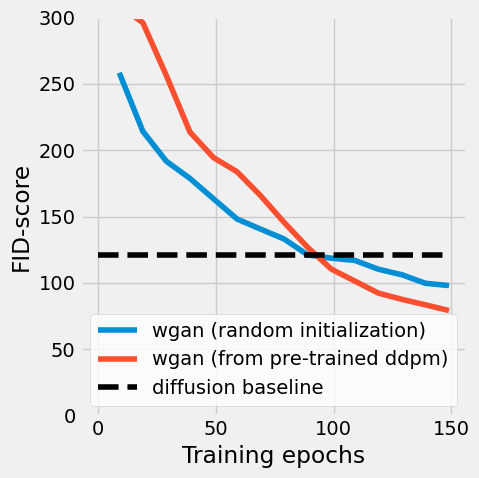

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor']=(1.0,1.0,1.0,0.0)
plt.rcParams['savefig.facecolor']=(1.0,1.0,1.0,0.0)
plt.figure(figsize=(5,5))

plt.plot(df_experiment_01["epoch"], df_experiment_01["fid_score"], label="wgan (random initialization)")
plt.plot(df_experiment_02B["epoch"], df_experiment_02B["fid_score"], label="wgan (from pre-trained ddpm)")
plt.hlines([120.7927], 0, max(df_experiment_01["epoch"].max(), df_experiment_02B["epoch"].max()), label="diffusion baseline", color="black", linestyles="dashed")

plt.ylim(0, 300)
# plt.grid()

plt.legend()
plt.xlabel("Training epochs")
plt.ylabel("FID-score")

plt.tight_layout()

# plt.show()
plt.savefig("gan_fid_scores.svg")